In [ ]:
import json
import ast

# Step 1: Load data from result.json
with open('resulttest.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Step 2: Load data from dataset (5).txt and prepare a dictionary of true triplets by sentence
true_triplets_from_text = {}
with open('test.txt', 'r', encoding='utf-8') as f:
    for line in f:
        sentence, triplets_str = line.strip().split("####")
        triplets = ast.literal_eval(triplets_str)
        true_triplets_from_text[sentence.strip()] = triplets

# Step 3: Match sentences and update True Triplets in data
for entry in data:
    if 'sentence' in entry:
        sentence = entry['sentence'].strip()
        if sentence in true_triplets_from_text:
            true_triplet_indices = true_triplets_from_text[sentence]
            true_triplets = []
            for indices in true_triplet_indices:
                aspect_indices, opinion_indices, polarity = indices
                aspect = " ".join(sentence.split()[i] for i in aspect_indices)
                opinion = " ".join(sentence.split()[i] for i in opinion_indices)
                polarity_dict = {'POS': 'Positive', 'NEG': 'Negative', 'NEU': 'Neutral'}
                true_triplets.append({
                    "Aspect": aspect,
                    "Opinion": opinion,
                    "Polarity": polarity_dict[polarity]
                })
            entry['True Triplets'] = true_triplets

# Step 4: Save the updated data to a new JSON file
with open('updated_results_test.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print("Updated results have been saved to 'updated_results.json'.")


Updated results have been saved to 'updated_results.json'.


In [ ]:
import json
import pandas as pd

# Input and output file paths
input_file = "updated_results_test.json"

# Output files for each condition
error_file = "error.csv"
cant_predict_file = "cant_predict.csv"
mispredict_file = "mispredict.csv"
matched_file = "matched.csv"

# Load data from JSON
with open(input_file, "r") as file:
    data = json.load(file)

# Initialize lists to store entries for each condition
error_data = []
cant_predict_data = []
mispredict_data = []
matched_data = []

# Filter entries based on conditions
for entry in data:
    if 'Triplets' not in entry or 'True Triplets' not in entry:
        error_data.append(entry)
        continue  # Skip entries without Triplets or True Triplets

    triplets = entry['Triplets']
    true_triplets = entry['True Triplets']

    if not true_triplets:
        error_data.append(entry)  # Both Triplets and True Triplets are empty
    elif not triplets and true_triplets:
        cant_predict_data.append(entry)  # Triplets are empty but True Triplets are not
    # elif triplets and not true_triplets:
    #     error_data.append(entry)  # True Triplets are empty but Triplets are not
    else:
        # If both Triplets and True Triplets are present
        triplet_set = {(t['Aspect'], t['Opinion'], t['Polarity']) for t in triplets}
        true_triplet_set = {(t['Aspect'], t['Opinion'], t['Polarity']) for t in true_triplets}

        if triplet_set == true_triplet_set:
            matched_data.append(entry)  # Triplets match True Triplets
        else:
            mispredict_data.append(entry)  # Triplets do not match True Triplets

# Convert lists to DataFrames
error_df = pd.DataFrame(error_data)
cant_predict_df = pd.DataFrame(cant_predict_data)
mispredict_df = pd.DataFrame(mispredict_data)
matched_df = pd.DataFrame(matched_data)

# Save DataFrames to CSV files
error_df.to_csv(error_file, index=False, encoding="utf-8")
cant_predict_df.to_csv(cant_predict_file, index=False, encoding="utf-8")
mispredict_df.to_csv(mispredict_file, index=False, encoding="utf-8")
matched_df.to_csv(matched_file, index=False, encoding="utf-8")

print(f"Filtered data has been saved to {error_file}, {cant_predict_file}, {mispredict_file}, and {matched_file}.")


Filtered data has been saved to error.csv, cant_predict.csv, mispredict.csv, and matched.csv.


Hitung Hasil Prediksi

In [ ]:
import pandas as pd

# Count entries in updated_results.json
with open('updated_results_test.json', 'r') as f:
    updated_results_count = len(json.load(f))

# Count rows in CSV files
error_count = len(pd.read_csv('error.csv'))
cant_predict_count = len(pd.read_csv('cant_predict.csv'))
mispredict_count = len(pd.read_csv('mispredict.csv'))
matched_count = len(pd.read_csv('matched.csv'))

# Print the counts with labels
print("Jumlah data yang diprediksi:", updated_results_count)
print("Hasil prediksi error:", error_count)
print("Model tidak dapat memprediksi hasil:", cant_predict_count)
print("Model salah memprediksi hasil:", mispredict_count)
print("Model memprediksi benar:", matched_count)


Jumlah data yang diprediksi: 443
Hasil prediksi error: 5
Model tidak dapat memprediksi hasil: 27
Model salah memprediksi hasil: 235
Model memprediksi benar: 176


Bedah Mispredict

In [ ]:
import json
import pandas as pd
import re

# Input and output file paths
mispredict_file = "mispredict.csv"

# Output files for each condition
cond1_partial_mistake_file = "cond1_partial_mistake.csv"
cond1_matched_aspect_opinion_file = "cond1_matched_aspect_opinion.csv"
cond1_all_wrong_file = "cond1_all_wrong.csv"
cond2_pred_more_all_match_file = "cond2_pred_more_all_match.csv"
cond2_pred_more_some_match_file = "cond2_pred_more_some_match.csv"
cond2_pred_less_some_match_file = "cond2_pred_less_some_match.csv"
cond2_pred_no_match_file = "cond2_pred_no_match.csv"

# Load data from mispredict.csv
mispredict_df = pd.read_csv(mispredict_file)

# Initialize lists to store entries for each condition
cond1_partial_mistake_data = []
cond1_matched_aspect_opinion_data = []
cond1_all_wrong_data = []
cond2_pred_more_all_match_data = []
cond2_pred_more_some_match_data = []
cond2_pred_less_some_match_data = []
cond2_pred_no_match_data = []

# Function to convert JSON string to list of dictionaries
def json_to_list(json_str):
    if pd.isna(json_str) or json_str == '[]':
        return []
    try:
        # Replace single quotes with double quotes
        json_str = json_str.replace("'", '"')
        # Fix common JSON errors
        json_str = re.sub(r',\s*}', '}', json_str)  # trailing commas before }
        json_str = re.sub(r',\s*]', ']', json_str)  # trailing commas before ]
        json_str = re.sub(r'(\w+):', r'"\1":', json_str)  # missing quotes for keys
        json_str = re.sub(r'""', r'"', json_str)  # remove double double quotes
        json_str = re.sub(r'"{', '{', json_str)  # remove quotes before {
        json_str = re.sub(r'}"', '}', json_str)  # remove quotes after }
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {json_str}\nError: {e}")
        raise

# Process each entry in the DataFrame
for index, row in mispredict_df.iterrows():
    triplets = json_to_list(row['Triplets'])
    true_triplets = json_to_list(row['True Triplets'])

    triplet_set = {(t['Aspect'], t['Opinion'], t['Polarity']) for t in triplets}
    true_triplet_set = {(t['Aspect'], t['Opinion'], t['Polarity']) for t in true_triplets}

    # Kondisi 1: Jumlah triplet sama antara "true triplet" dan "triplet"
    if len(triplets) == len(true_triplets):
        partially_mistake = False
        matched_aspect_opinion = False
        all_wrong = False

        for t in triplets:
            t_tuple = (t['Aspect'], t['Opinion'])
            if t_tuple not in {(tt['Aspect'], tt['Opinion']) for tt in true_triplets}:
                partially_mistake = True
            elif any(t_tuple == (tt['Aspect'], tt['Opinion']) and t['Polarity'] != tt['Polarity'] for tt in true_triplets):
                matched_aspect_opinion = True
            elif t_tuple not in true_triplet_set:
                all_wrong = True

        if partially_mistake:
            cond1_partial_mistake_data.append(row.to_dict())
        elif matched_aspect_opinion:
            cond1_matched_aspect_opinion_data.append(row.to_dict())
        elif all_wrong:
            cond1_all_wrong_data.append(row.to_dict())

    # Kondisi 2 : Jumlah triplet tidak sama antara "true triplet" dan "triplet"
    else:
        if len(triplets) > len(true_triplets):
            all_match = all(tt in triplet_set for tt in true_triplet_set)
            some_match = any(tt in triplet_set for tt in true_triplet_set)

            if all_match:
                cond2_pred_more_all_match_data.append(row.to_dict())
            elif some_match:
                cond2_pred_more_some_match_data.append(row.to_dict())
            else:
                cond2_pred_no_match_data.append(row.to_dict())

        elif len(triplets) < len(true_triplets):
            some_match = any(tt in triplet_set for tt in true_triplet_set)
            no_extra_triplet = all(t in true_triplet_set for t in triplet_set)

            if some_match and no_extra_triplet:
                cond2_pred_less_some_match_data.append(row.to_dict())
            elif some_match and not no_extra_triplet:
                cond2_pred_more_some_match_data.append(row.to_dict())
            else:
                cond2_pred_no_match_data.append(row.to_dict())

# Convert lists to DataFrames
cond1_partial_mistake_df = pd.DataFrame(cond1_partial_mistake_data)
cond1_matched_aspect_opinion_df = pd.DataFrame(cond1_matched_aspect_opinion_data)
cond1_all_wrong_df = pd.DataFrame(cond1_all_wrong_data)
cond2_pred_more_all_match_df = pd.DataFrame(cond2_pred_more_all_match_data)
cond2_pred_more_some_match_df = pd.DataFrame(cond2_pred_more_some_match_data)
cond2_pred_less_some_match_df = pd.DataFrame(cond2_pred_less_some_match_data)
cond2_pred_no_match_df = pd.DataFrame(cond2_pred_no_match_data)

# Save DataFrames to CSV files
cond1_partial_mistake_df.to_csv(cond1_partial_mistake_file, index=False, encoding="utf-8")
cond1_matched_aspect_opinion_df.to_csv(cond1_matched_aspect_opinion_file, index=False, encoding="utf-8")
cond1_all_wrong_df.to_csv(cond1_all_wrong_file, index=False, encoding="utf-8")
cond2_pred_more_all_match_df.to_csv(cond2_pred_more_all_match_file, index=False, encoding="utf-8")
cond2_pred_more_some_match_df.to_csv(cond2_pred_more_some_match_file, index=False, encoding="utf-8")
cond2_pred_less_some_match_df.to_csv(cond2_pred_less_some_match_file, index=False, encoding="utf-8")
cond2_pred_no_match_df.to_csv(cond2_pred_no_match_file, index=False, encoding="utf-8")

print(f"Filtered mispredict data has been saved to the respective files.")


Filtered mispredict data has been saved to the respective files.


Hitung mispredict

In [ ]:
import os
import pandas as pd

# File paths
cond1_partial_mistake_file = "cond1_partial_mistake.csv"
cond1_matched_aspect_opinion_file = "cond1_matched_aspect_opinion.csv"
cond1_all_wrong_file = "cond1_all_wrong.csv"
cond2_pred_more_all_match_file = "cond2_pred_more_all_match.csv"
cond2_pred_more_some_match_file = "cond2_pred_more_some_match.csv"
cond2_pred_less_some_match_file = "cond2_pred_less_some_match.csv"
cond2_pred_no_match_file = "cond2_pred_no_match.csv"

# Count rows in each file
cond1_partial_mistake_count = len(pd.read_csv(cond1_partial_mistake_file)) if os.path.exists(cond1_partial_mistake_file) else 0
cond1_matched_aspect_opinion_count = len(pd.read_csv(cond1_matched_aspect_opinion_file)) if os.path.exists(cond1_matched_aspect_opinion_file) else 0
cond1_all_wrong_count = len(pd.read_csv(cond1_all_wrong_file)) if os.path.exists(cond1_all_wrong_file) else 0
cond2_pred_more_all_match_count = len(pd.read_csv(cond2_pred_more_all_match_file)) if os.path.exists(cond2_pred_more_all_match_file) else 0
cond2_pred_more_some_match_count = len(pd.read_csv(cond2_pred_more_some_match_file)) if os.path.exists(cond2_pred_more_some_match_file) else 0
cond2_pred_less_some_match_count = len(pd.read_csv(cond2_pred_less_some_match_file)) if os.path.exists(cond2_pred_less_some_match_file) else 0
cond2_pred_no_match_count = len(pd.read_csv(cond2_pred_no_match_file)) if os.path.exists(cond2_pred_no_match_file) else 0

# Print the counts
print(f"Number of entries in cond1_partial_mistake.csv: {cond1_partial_mistake_count}")
print(f"Number of entries in cond1_matched_aspect_opinion.csv: {cond1_matched_aspect_opinion_count}")
print(f"Number of entries in cond1_all_wrong.csv: {cond1_all_wrong_count}")
print(f"Number of entries in cond2_pred_more_all_match.csv: {cond2_pred_more_all_match_count}")
print(f"Number of entries in cond2_pred_more_some_match.csv: {cond2_pred_more_some_match_count}")
print(f"Number of entries in cond2_pred_less_some_match.csv: {cond2_pred_less_some_match_count}")
print(f"Number of entries in cond2_pred_no_match.csv: {cond2_pred_no_match_count}")


Number of entries in cond1_partial_mistake.csv: 56
Number of entries in cond1_matched_aspect_opinion.csv: 5
Number of entries in cond1_all_wrong.csv: 4
Number of entries in cond2_pred_more_all_match.csv: 86
Number of entries in cond2_pred_more_some_match.csv: 45
Number of entries in cond2_pred_less_some_match.csv: 11
Number of entries in cond2_pred_no_match.csv: 32


Bedah Partial Mistake

In [ ]:
import pandas as pd
import json
import re

# File paths for saving results
cond1_partial_mistake_aspect_incorrect_file = "cond1_partial_mistake_aspect_incorrect.csv"
cond1_partial_mistake_opinion_incorrect_file = "cond1_partial_mistake_opinion_incorrect.csv"
cond1_partial_mistake_polarity_correct_file = "cond1_partial_mistake_polarity_correct.csv"
cond1_partial_mistake_aspect_correct_file = "cond1_partial_mistake_aspect_correct.csv"
cond1_partial_mistake_opinion_correct_file = "cond1_partial_mistake_opinion_correct.csv"
cond1_all_wrong_file = "cond1_all_wrong.csv"

# Function to convert JSON string to list of dictionaries
def json_to_list(json_str):
    if pd.isna(json_str) or json_str == '[]':
        return []
    try:
        # Replace single quotes with double quotes
        json_str = json_str.replace("'", '"')
        # Fix common JSON errors
        json_str = re.sub(r',\s*}', '}', json_str)  # trailing commas before }
        json_str = re.sub(r',\s*]', ']', json_str)  # trailing commas before ]
        json_str = re.sub(r'(\w+):', r'"\1":', json_str)  # missing quotes for keys
        json_str = re.sub(r'""', r'"', json_str)  # remove double double quotes
        json_str = re.sub(r'"{', '{', json_str)  # remove quotes before {
        json_str = re.sub(r'}"', '}', json_str)  # remove quotes after }
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {json_str}\nError: {e}")
        raise

# Load data from cond1_partial_mistake.csv
cond1_partial_mistake_file = "cond1_partial_mistake.csv"
cond1_partial_mistake_df = pd.read_csv(cond1_partial_mistake_file)

# Initialize lists to store data for each category
cond1_partial_mistake_aspect_incorrect_data = []
cond1_partial_mistake_opinion_incorrect_data = []
cond1_partial_mistake_polarity_correct_data = []
cond1_partial_mistake_aspect_correct_data = []
cond1_partial_mistake_opinion_correct_data = []
cond1_all_wrong_data = []

# Process each entry in the DataFrame
for index, row in cond1_partial_mistake_df.iterrows():
    triplets = json_to_list(row['Triplets'])
    true_triplets = json_to_list(row['True Triplets'])

    aspect_incorrect = False
    opinion_incorrect = False
    polarity_correct = False
    aspect_correct = False
    opinion_correct = False
    all_wrong = True

    # Check if there's only one triplet
    if len(triplets) == 1:
        t = triplets[0]
        true_triplet = true_triplets[0]

        if t['Aspect'] != true_triplet['Aspect'] and t['Opinion'] == true_triplet['Opinion'] and t['Polarity'] == true_triplet['Polarity']:
            aspect_incorrect = True
            all_wrong = False
        elif t['Opinion'] != true_triplet['Opinion'] and t['Aspect'] == true_triplet['Aspect'] and t['Polarity'] == true_triplet['Polarity']:
            opinion_incorrect = True
            all_wrong = False
        elif t['Opinion'] != true_triplet['Opinion'] and t['Aspect'] == true_triplet['Aspect'] and t['Polarity'] != true_triplet['Polarity']:
            aspect_correct = True
            all_wrong = False
        elif t['Opinion'] == true_triplet['Opinion'] and t['Aspect'] != true_triplet['Aspect'] and t['Polarity'] != true_triplet['Polarity']:
            opinion_correct = True
            all_wrong = False
        elif t['Opinion'] != true_triplet['Opinion'] and t['Aspect'] != true_triplet['Aspect'] and t['Polarity'] == true_triplet['Polarity']:
            polarity_correct = True
            all_wrong = False

    # Check if there are multiple triplets (handled as before)
    else:
        for t in triplets:
            t_tuple = (t['Aspect'], t['Opinion'])
            true_tuple_set = {(tt['Aspect'], tt['Opinion']) for tt in true_triplets}

            if not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct or opinion_correct):
                if any(t['Aspect'] != tt['Aspect'] and t['Opinion'] == tt['Opinion'] and t['Polarity'] == tt['Polarity'] for tt in true_triplets):
                    aspect_incorrect = True
                    all_wrong = False
                elif any(t['Opinion'] != tt['Opinion'] and t['Aspect'] == tt['Aspect'] and t['Polarity'] == tt['Polarity'] for tt in true_triplets):
                    opinion_incorrect = True
                    all_wrong = False
                elif any(t['Opinion'] != tt['Opinion'] and t['Aspect'] == tt['Aspect'] and t['Polarity'] != tt['Polarity'] for tt in true_triplets):
                    aspect_correct = True
                    all_wrong = False
                elif any(t['Opinion'] == tt['Opinion'] and t['Aspect'] != tt['Aspect'] and t['Polarity'] != tt['Polarity'] for tt in true_triplets):
                    opinion_correct = True
                    all_wrong = False
                elif any(t['Opinion'] != tt['Opinion'] and t['Aspect'] != tt['Aspect'] and t['Polarity'] == tt['Polarity'] for tt in true_triplets):
                    polarity_correct = True
                    all_wrong = False

    # Append data to respective lists
    if aspect_incorrect and not (opinion_incorrect or polarity_correct or aspect_correct or opinion_correct):
        cond1_partial_mistake_aspect_incorrect_data.append(row.to_dict())
    elif opinion_incorrect and not (aspect_incorrect or polarity_correct or aspect_correct or opinion_correct):
        cond1_partial_mistake_opinion_incorrect_data.append(row.to_dict())
    elif polarity_correct and not (aspect_incorrect or opinion_incorrect or aspect_correct or opinion_correct):
        cond1_partial_mistake_polarity_correct_data.append(row.to_dict())
    elif aspect_correct and not (aspect_incorrect or opinion_incorrect or polarity_correct or opinion_correct):
        cond1_partial_mistake_aspect_correct_data.append(row.to_dict())
    elif opinion_correct and not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct):
        cond1_partial_mistake_opinion_correct_data.append(row.to_dict())
    elif all_wrong and not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct or opinion_correct):
        cond1_all_wrong_data.append(row.to_dict())

# Convert lists to DataFrames
cond1_partial_mistake_aspect_incorrect_df = pd.DataFrame(cond1_partial_mistake_aspect_incorrect_data)
cond1_partial_mistake_opinion_incorrect_df = pd.DataFrame(cond1_partial_mistake_opinion_incorrect_data)
cond1_partial_mistake_polarity_correct_df = pd.DataFrame(cond1_partial_mistake_polarity_correct_data)
cond1_partial_mistake_aspect_correct_df = pd.DataFrame(cond1_partial_mistake_aspect_correct_data)
cond1_partial_mistake_opinion_correct_df = pd.DataFrame(cond1_partial_mistake_opinion_correct_data)
cond1_all_wrong_df = pd.DataFrame(cond1_all_wrong_data)

# Save DataFrames to CSV files
cond1_partial_mistake_aspect_incorrect_df.to_csv(cond1_partial_mistake_aspect_incorrect_file, index=False, encoding="utf-8")
cond1_partial_mistake_opinion_incorrect_df.to_csv(cond1_partial_mistake_opinion_incorrect_file, index=False, encoding="utf-8")
cond1_partial_mistake_polarity_correct_df.to_csv(cond1_partial_mistake_polarity_correct_file, index=False, encoding="utf-8")
cond1_partial_mistake_aspect_correct_df.to_csv(cond1_partial_mistake_aspect_correct_file, index=False, encoding="utf-8")
cond1_partial_mistake_opinion_correct_df.to_csv(cond1_partial_mistake_opinion_correct_file, index=False, encoding="utf-8")
cond1_all_wrong_df.to_csv(cond1_all_wrong_file, index=False, encoding="utf-8")

print("Data has been saved for each category.")


Data has been saved for each category.


Hitung partial

In [ ]:
import pandas as pd
# Count the number of entries in each category
num_aspect_incorrect = len(cond1_partial_mistake_aspect_incorrect_df)
num_opinion_incorrect = len(cond1_partial_mistake_opinion_incorrect_df)
num_polarity_correct = len(cond1_partial_mistake_polarity_correct_df)
num_aspect_correct = len(cond1_partial_mistake_aspect_correct_df)
num_opinion_correct = len(cond1_partial_mistake_opinion_correct_df)
num_all_wrong = len(cond1_all_wrong_df)

# Calculate the total
total_categories = num_aspect_incorrect + num_opinion_incorrect + num_polarity_correct + num_aspect_correct + num_opinion_correct + num_all_wrong

# Load the original cond1_partial_mistake data
cond1_partial_mistake_df = pd.read_csv(cond1_partial_mistake_file)
total_cond1_partial_mistake = len(cond1_partial_mistake_df)

# Print the results
print("Count for each category:")
print(f"Aspect Incorrect: {num_aspect_incorrect}")
print(f"Opinion Incorrect: {num_opinion_incorrect}")
print(f"Polarity Correct: {num_polarity_correct}")
print(f"Aspect Correct: {num_aspect_correct}")
print(f"Opinion Correct: {num_opinion_correct}")
print(f"All Wrong: {num_all_wrong}")
print(f"Total from Categories: {total_categories}")
print(f"Total from cond1_partial_mistake.csv: {total_cond1_partial_mistake}")

# Check if the total matches the original count
if total_categories == total_cond1_partial_mistake:
    print("The total count from categories matches the count in cond1_partial_mistake.csv.")
else:
    print("The total count from categories does not match the count in cond1_partial_mistake.csv. There might be overlapping entries.")



Count for each category:
Aspect Incorrect: 24
Opinion Incorrect: 13
Polarity Correct: 8
Aspect Correct: 6
Opinion Correct: 1
All Wrong: 4
Total from Categories: 56
Total from cond1_partial_mistake.csv: 56
The total count from categories matches the count in cond1_partial_mistake.csv.


Bedah Some Match No Match

In [ ]:
import pandas as pd
import json
import re

# File paths for saving results
cond2_pred_more_some_match_aspect_incorrect_file = "cond2_pred_more_some_match_aspect_incorrect.csv"
cond2_pred_more_some_match_opinion_incorrect_file = "cond2_pred_more_some_match_opinion_incorrect.csv"
cond2_pred_more_some_match_polarity_correct_file = "cond2_pred_more_some_match_polarity_correct.csv"
cond2_pred_more_some_match_polarity_incorrect_file = "cond2_pred_more_some_match_polarity_incorrect.csv"
cond2_pred_more_some_match_aspect_correct_file = "cond2_pred_more_some_match_aspect_correct.csv"
cond2_pred_more_some_match_opinion_correct_file = "cond2_pred_more_some_match_opinion_correct.csv"
cond2_all_wrong_file = "cond2_all_wrong.csv"

# Function to convert JSON string to list of dictionaries
def json_to_list(json_str):
    if pd.isna(json_str) or json_str == '[]':
        return []
    try:
        # Replace single quotes with double quotes
        json_str = json_str.replace("'", '"')
        # Fix common JSON errors
        json_str = re.sub(r',\s*}', '}', json_str)  # trailing commas before }
        json_str = re.sub(r',\s*]', ']', json_str)  # trailing commas before ]
        json_str = re.sub(r'(\w+):', r'"\1":', json_str)  # missing quotes for keys
        json_str = re.sub(r'""', r'"', json_str)  # remove double double quotes
        json_str = re.sub(r'"{', '{', json_str)  # remove quotes before {
        json_str = re.sub(r'}"', '}', json_str)  # remove quotes after }
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {json_str}\nError: {e}")
        raise

# Load data from cond2_pred_more_some_match.csv
cond2_pred_more_some_match_file = "cond2_pred_more_some_match.csv"
cond2_pred_more_some_match_df = pd.read_csv(cond2_pred_more_some_match_file)

# Initialize lists to store data for each category
cond2_pred_more_some_match_aspect_incorrect_data = []
cond2_pred_more_some_match_opinion_incorrect_data = []
cond2_pred_more_some_match_polarity_correct_data = []
cond2_pred_more_some_match_polarity_incorrect_data = []
cond2_pred_more_some_match_aspect_correct_data = []
cond2_pred_more_some_match_opinion_correct_data = []
cond2_all_wrong_data = []

# Process each entry in the DataFrame
for index, row in cond2_pred_more_some_match_df.iterrows():
    triplets = json_to_list(row['Triplets'])
    true_triplets = json_to_list(row['True Triplets'])

    aspect_incorrect = False
    opinion_incorrect = False
    polarity_correct = False
    polarity_incorrect = False
    aspect_correct = False
    opinion_correct = False
    all_wrong = True

    # Check if there's only one triplet
    if len(triplets) == 1:
        t = triplets[0]
        true_triplet = true_triplets[0]

        if t['Aspect'] != true_triplet['Aspect'] and t['Opinion'] == true_triplet['Opinion'] and t['Polarity'] == true_triplet['Polarity']:
            aspect_incorrect = True
            all_wrong = False
        elif t['Opinion'] != true_triplet['Opinion'] and t['Aspect'] == true_triplet['Aspect'] and t['Polarity'] == true_triplet['Polarity']:
            opinion_incorrect = True
            all_wrong = False
        elif t['Opinion'] != true_triplet['Opinion'] and t['Aspect'] == true_triplet['Aspect'] and t['Polarity'] != true_triplet['Polarity']:
            aspect_correct = True
            all_wrong = False
        elif t['Opinion'] == true_triplet['Opinion'] and t['Aspect'] != true_triplet['Aspect'] and t['Polarity'] != true_triplet['Polarity']:
            opinion_correct = True
            all_wrong = False
        elif t['Opinion'] != true_triplet['Opinion'] and t['Aspect'] != true_triplet['Aspect'] and t['Polarity'] == true_triplet['Polarity']:
            polarity_correct = True
            all_wrong = False
        elif t['Opinion'] == true_triplet['Opinion'] and t['Aspect'] == true_triplet['Aspect'] and t['Polarity'] != true_triplet['Polarity']:
            polarity_incorrect = True
            all_wrong = False

    # Check if there are multiple triplets (handled as before)
    else:
        for t in triplets:
            t_tuple = (t['Aspect'], t['Opinion'])
            true_tuple_set = {(tt['Aspect'], tt['Opinion']) for tt in true_triplets}

            if not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct or opinion_correct):
                if any(t['Aspect'] != tt['Aspect'] and t['Opinion'] == tt['Opinion'] and t['Polarity'] == tt['Polarity'] for tt in true_triplets):
                    aspect_incorrect = True
                    all_wrong = False
                elif any(t['Opinion'] != tt['Opinion'] and t['Aspect'] == tt['Aspect'] and t['Polarity'] == tt['Polarity'] for tt in true_triplets):
                    opinion_incorrect = True
                    all_wrong = False
                elif any(t['Opinion'] != tt['Opinion'] and t['Aspect'] == tt['Aspect'] and t['Polarity'] != tt['Polarity'] for tt in true_triplets):
                    aspect_correct = True
                    all_wrong = False
                elif any(t['Opinion'] == tt['Opinion'] and t['Aspect'] != tt['Aspect'] and t['Polarity'] != tt['Polarity'] for tt in true_triplets):
                    opinion_correct = True
                    all_wrong = False
                elif any(t['Opinion'] != tt['Opinion'] and t['Aspect'] != tt['Aspect'] and t['Polarity'] == tt['Polarity'] for tt in true_triplets):
                    polarity_correct = True
                    all_wrong = False
                elif any(t['Opinion'] == tt['Opinion'] and t['Aspect'] == tt['Aspect'] and t['Polarity'] != tt['Polarity'] for tt in true_triplets):
                    polarity_incorrect = True
                    all_wrong = False

    # Append data to respective lists
    if aspect_incorrect and not (opinion_incorrect or polarity_correct or aspect_correct or opinion_correct or polarity_incorrect):
        cond2_pred_more_some_match_aspect_incorrect_data.append(row.to_dict())
    elif opinion_incorrect and not (aspect_incorrect or polarity_correct or aspect_correct or opinion_correct or polarity_incorrect):
        cond2_pred_more_some_match_opinion_incorrect_data.append(row.to_dict())
    elif polarity_correct and not (aspect_incorrect or opinion_incorrect or aspect_correct or opinion_correct or polarity_incorrect):
        cond2_pred_more_some_match_polarity_correct_data.append(row.to_dict())
    elif aspect_correct and not (aspect_incorrect or opinion_incorrect or polarity_correct or opinion_correct or polarity_incorrect):
        cond2_pred_more_some_match_aspect_correct_data.append(row.to_dict())
    elif opinion_correct and not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct or polarity_incorrect):
        cond2_pred_more_some_match_opinion_correct_data.append(row.to_dict())
    elif polarity_incorrect and not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct or opinion_correct):
        cond2_pred_more_some_match_polarity_incorrect_data.append(row.to_dict())
    elif all_wrong and not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct or opinion_correct or polarity_incorrect):
        cond2_all_wrong_data.append(row.to_dict())

# Convert lists to DataFrames
cond2_pred_more_some_match_aspect_incorrect_df = pd.DataFrame(cond2_pred_more_some_match_aspect_incorrect_data)
cond2_pred_more_some_match_opinion_incorrect_df = pd.DataFrame(cond2_pred_more_some_match_opinion_incorrect_data)
cond2_pred_more_some_match_polarity_correct_df = pd.DataFrame(cond2_pred_more_some_match_polarity_correct_data)
cond2_pred_more_some_match_aspect_correct_df = pd.DataFrame(cond2_pred_more_some_match_aspect_correct_data)
cond2_pred_more_some_match_opinion_correct_df = pd.DataFrame(cond2_pred_more_some_match_opinion_correct_data)
cond2_pred_more_some_match_polarity_incorrect_df = pd.DataFrame(cond2_pred_more_some_match_polarity_incorrect_data)
cond2_all_wrong_df = pd.DataFrame(cond2_all_wrong_data)

# Save DataFrames to CSV files
cond2_pred_more_some_match_aspect_incorrect_df.to_csv(cond2_pred_more_some_match_aspect_incorrect_file, index=False, encoding="utf-8")
cond2_pred_more_some_match_opinion_incorrect_df.to_csv(cond2_pred_more_some_match_opinion_incorrect_file, index=False, encoding="utf-8")
cond2_pred_more_some_match_polarity_correct_df.to_csv(cond2_pred_more_some_match_polarity_correct_file, index=False, encoding="utf-8")
cond2_pred_more_some_match_aspect_correct_df.to_csv(cond2_pred_more_some_match_aspect_correct_file, index=False, encoding="utf-8")
cond2_pred_more_some_match_opinion_correct_df.to_csv(cond2_pred_more_some_match_opinion_correct_file, index=False, encoding="utf-8")
cond2_pred_more_some_match_polarity_incorrect_df.to_csv(cond2_pred_more_some_match_polarity_incorrect_file, index=False, encoding="utf-8")
cond2_all_wrong_df.to_csv(cond2_all_wrong_file, index=False, encoding="utf-8")

print("Data has been saved for each category.")

Data has been saved for each category.


In [ ]:
import pandas as pd
import json
import re

# File paths for saving results
cond2_pred_no_match_aspect_incorrect_file = "cond2_pred_no_match_aspect_incorrect.csv"
cond2_pred_no_match_opinion_incorrect_file = "cond2_pred_no_match_opinion_incorrect.csv"
cond2_pred_no_match_polarity_correct_file = "cond2_pred_no_match_polarity_correct.csv"
cond2_pred_no_match_aspect_correct_file = "cond2_pred_no_match_aspect_correct.csv"
cond2_pred_no_match_opinion_correct_file = "cond2_pred_no_match_opinion_correct.csv"
cond2_all_wrong_file = "cond2_all_wrong.csv"
cond2_pred_no_match_polarity_incorrect_file = "cond2_pred_no_match_polarity_incorrect.csv"

# Function to convert JSON string to list of dictionaries
def json_to_list(json_str):
    if pd.isna(json_str) or json_str == '[]':
        return []
    try:
        # Replace single quotes with double quotes
        json_str = json_str.replace("'", '"')
        # Fix common JSON errors
        json_str = re.sub(r',\s*}', '}', json_str)  # trailing commas before }
        json_str = re.sub(r',\s*]', ']', json_str)  # trailing commas before ]
        json_str = re.sub(r'(\w+):', r'"\1":', json_str)  # missing quotes for keys
        json_str = re.sub(r'""', r'"', json_str)  # remove double double quotes
        json_str = re.sub(r'"{', '{', json_str)  # remove quotes before {
        json_str = re.sub(r'}"', '}', json_str)  # remove quotes after }
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {json_str}\nError: {e}")
        raise

# Load data from cond2_pred_no_match.csv
cond2_pred_no_match_file = "cond2_pred_no_match.csv"
cond2_pred_no_match_df = pd.read_csv(cond2_pred_no_match_file)

# Initialize lists to store data for each category
cond2_pred_no_match_aspect_incorrect_data = []
cond2_pred_no_match_opinion_incorrect_data = []
cond2_pred_no_match_polarity_correct_data = []
cond2_pred_no_match_aspect_correct_data = []
cond2_pred_no_match_opinion_correct_data = []
cond2_all_wrong_data = []
cond2_pred_no_match_polarity_incorrect_data = []

# Process each entry in the DataFrame
for index, row in cond2_pred_no_match_df.iterrows():
    triplets = json_to_list(row['Triplets'])
    true_triplets = json_to_list(row['True Triplets'])

    aspect_incorrect = False
    opinion_incorrect = False
    polarity_correct = False
    aspect_correct = False
    opinion_correct = False
    all_wrong = True
    polarity_incorrect = False

    # Check if there's only one triplet
    if len(triplets) == 1:
        t = triplets[0]
        true_triplet = true_triplets[0]

        if t['Aspect'] != true_triplet['Aspect'] and t['Opinion'] == true_triplet['Opinion'] and t['Polarity'] == true_triplet['Polarity']:
            aspect_incorrect = True
            all_wrong = False
        elif t['Opinion'] != true_triplet['Opinion'] and t['Aspect'] == true_triplet['Aspect'] and t['Polarity'] == true_triplet['Polarity']:
            opinion_incorrect = True
            all_wrong = False
        elif t['Opinion'] != true_triplet['Opinion'] and t['Aspect'] == true_triplet['Aspect'] and t['Polarity'] != true_triplet['Polarity']:
            aspect_correct = True
            all_wrong = False
        elif t['Opinion'] == true_triplet['Opinion'] and t['Aspect'] != true_triplet['Aspect'] and t['Polarity'] != true_triplet['Polarity']:
            opinion_correct = True
            all_wrong = False
        elif t['Polarity'] == true_triplet['Polarity']:
            polarity_correct = True
            all_wrong = False
        elif t['Opinion'] == true_triplet['Opinion'] and t['Aspect'] == true_triplet['Aspect'] and t['Polarity'] != true_triplet['Polarity']:
            polarity_incorrect = True
            all_wrong = False

    # Check if there are multiple triplets (handled as before)
    else:
        for t in triplets:
            t_tuple = (t['Aspect'], t['Opinion'])
            true_tuple_set = {(tt['Aspect'], tt['Opinion']) for tt in true_triplets}

            if not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct or opinion_correct or polarity_incorrect):
                if any(t['Aspect'] != tt['Aspect'] and t['Opinion'] == tt['Opinion'] and t['Polarity'] == tt['Polarity'] for tt in true_triplets):
                    aspect_incorrect = True
                    all_wrong = False
                elif any(t['Opinion'] != tt['Opinion'] and t['Aspect'] == tt['Aspect'] and t['Polarity'] == tt['Polarity'] for tt in true_triplets):
                    opinion_incorrect = True
                    all_wrong = False
                elif any(t['Opinion'] != tt['Opinion'] and t['Aspect'] == tt['Aspect'] and t['Polarity'] != tt['Polarity'] for tt in true_triplets):
                    aspect_correct = True
                    all_wrong = False
                elif any(t['Opinion'] == tt['Opinion'] and t['Aspect'] != tt['Aspect'] and t['Polarity'] != tt['Polarity'] for tt in true_triplets):
                    opinion_correct = True
                    all_wrong = False
                elif t_tuple in true_tuple_set and t['Polarity'] == next((tt['Polarity'] for tt in true_triplets if (tt['Aspect'], tt['Opinion']) != t_tuple), None):
                    polarity_correct = True
                    all_wrong = False
                elif t_tuple in true_tuple_set and t['Polarity'] != next((tt['Polarity'] for tt in true_triplets if (tt['Aspect'], tt['Opinion']) == t_tuple), None):
                    polarity_incorrect = True
                    all_wrong = False

    # Append data to respective lists
    if aspect_incorrect and not (opinion_incorrect or polarity_correct or aspect_correct or opinion_correct or polarity_incorrect):
        cond2_pred_no_match_aspect_incorrect_data.append(row.to_dict())
    elif opinion_incorrect and not (aspect_incorrect or polarity_correct or aspect_correct or opinion_correct or polarity_incorrect):
        cond2_pred_no_match_opinion_incorrect_data.append(row.to_dict())
    elif polarity_correct and not (aspect_incorrect or opinion_incorrect or aspect_correct or opinion_correct or polarity_incorrect):
        cond2_pred_no_match_polarity_correct_data.append(row.to_dict())
    elif aspect_correct and not (aspect_incorrect or opinion_incorrect or polarity_correct or opinion_correct or polarity_incorrect):
        cond2_pred_no_match_aspect_correct_data.append(row.to_dict())
    elif opinion_correct and not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct or polarity_incorrect):
        cond2_pred_no_match_opinion_correct_data.append(row.to_dict())
    elif polarity_incorrect and not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct or opinion_correct):
        cond2_pred_no_match_polarity_incorrect_data.append(row.to_dict())
    elif all_wrong and not (aspect_incorrect or opinion_incorrect or polarity_correct or aspect_correct or opinion_correct or polarity_incorrect):
        cond2_all_wrong_data.append(row.to_dict())

# Convert lists to DataFrames
cond2_pred_no_match_aspect_incorrect_df = pd.DataFrame(cond2_pred_no_match_aspect_incorrect_data)
cond2_pred_no_match_opinion_incorrect_df = pd.DataFrame(cond2_pred_no_match_opinion_incorrect_data)
cond2_pred_no_match_polarity_correct_df = pd.DataFrame(cond2_pred_no_match_polarity_correct_data)
cond2_pred_no_match_aspect_correct_df = pd.DataFrame(cond2_pred_no_match_aspect_correct_data)
cond2_pred_no_match_opinion_correct_df = pd.DataFrame(cond2_pred_no_match_opinion_correct_data)
cond2_pred_no_match_polarity_incorrect_df = pd.DataFrame(cond2_pred_no_match_polarity_incorrect_data)
cond2_all_wrong_df = pd.DataFrame(cond2_all_wrong_data)

# Save DataFrames to CSV files
cond2_pred_no_match_aspect_incorrect_df.to_csv(cond2_pred_no_match_aspect_incorrect_file, index=False, encoding="utf-8")
cond2_pred_no_match_opinion_incorrect_df.to_csv(cond2_pred_no_match_opinion_incorrect_file, index=False, encoding="utf-8")
cond2_pred_no_match_polarity_correct_df.to_csv(cond2_pred_no_match_polarity_correct_file, index=False, encoding="utf-8")
cond2_pred_no_match_aspect_correct_df.to_csv(cond2_pred_no_match_aspect_correct_file, index=False, encoding="utf-8")
cond2_pred_no_match_opinion_correct_df.to_csv(cond2_pred_no_match_opinion_correct_file, index=False, encoding="utf-8")
cond2_pred_no_match_polarity_incorrect_df.to_csv(cond2_pred_no_match_polarity_incorrect_file, index=False, encoding="utf-8")
cond2_all_wrong_df.to_csv(cond2_all_wrong_file, index=False, encoding="utf-8")

print("Data has been saved for each category.")


Data has been saved for each category.


Hitung Some Match No Match

In [ ]:
# prompt: count hasil diatas dan totalnya kemudian bandingkan dengan cond2_more_some_match dan cond2_no_match

import pandas as pd

# Count the number of entries in each category for cond2_pred_more_some_match
num_aspect_incorrect_some_match = len(pd.read_csv("cond2_pred_more_some_match_aspect_incorrect.csv"))
num_opinion_incorrect_some_match = len(pd.read_csv("cond2_pred_more_some_match_opinion_incorrect.csv"))
num_polarity_correct_some_match = len(pd.read_csv("cond2_pred_more_some_match_polarity_correct.csv"))
num_aspect_correct_some_match = len(pd.read_csv("cond2_pred_more_some_match_aspect_correct.csv"))
# num_opinion_correct_some_match = len(pd.read_csv("cond2_pred_more_some_match_opinion_correct.csv"))
# num_all_wrong_some_match = len(pd.read_csv("cond2_all_wrong.csv"))
# num_polarity_incorrect_some_match = len(pd.read_csv("cond2_pred_more_some_match_polarity_incorrect.csv"))

# Calculate the total for cond2_pred_more_some_match
total_categories_some_match = num_aspect_incorrect_some_match + num_opinion_incorrect_some_match + num_polarity_correct_some_match + \
                               num_aspect_correct_some_match #+ num_polarity_incorrect_some_match #+ num_opinion_correct_some_match + num_all_wrong_some_match

# Load the original cond2_pred_more_some_match data
cond2_pred_more_some_match_df = pd.read_csv("cond2_pred_more_some_match.csv")
total_cond2_pred_more_some_match = len(cond2_pred_more_some_match_df)

# Print the results for cond2_pred_more_some_match
print("\nCount for each category in cond2_pred_more_some_match:")
print(f"Aspect Incorrect: {num_aspect_incorrect_some_match}")
print(f"Opinion Incorrect: {num_opinion_incorrect_some_match}")
print(f"Polarity Correct: {num_polarity_correct_some_match}")
print(f"Aspect Correct: {num_aspect_correct_some_match}")
# print(f"Opinion Correct: {num_opinion_correct_some_match}")
# print(f"All Wrong: {num_all_wrong_some_match}")
print(f"Total from Categories: {total_categories_some_match}")
print(f"Total from cond2_pred_more_some_match.csv: {total_cond2_pred_more_some_match}")

# Check if the total matches the original count for cond2_pred_more_some_match
if total_categories_some_match == total_cond2_pred_more_some_match:
    print("The total count from categories matches the count in cond2_pred_more_some_match.csv.")
else:
    print("The total count from categories does not match the count in cond2_pred_more_some_match.csv. There might be overlapping entries.")

# Count the number of entries in each category for cond2_pred_more_no_match
num_aspect_incorrect_no_match = len(pd.read_csv("cond2_pred_no_match_aspect_incorrect.csv"))
num_opinion_incorrect_no_match = len(pd.read_csv("cond2_pred_no_match_opinion_incorrect.csv"))
num_polarity_correct_no_match = len(pd.read_csv("cond2_pred_no_match_polarity_correct.csv"))
num_aspect_correct_no_match = len(pd.read_csv("cond2_pred_no_match_aspect_correct.csv"))
num_opinion_correct_no_match = len(pd.read_csv("cond2_pred_no_match_opinion_correct.csv"))
num_all_wrong_no_match = len(pd.read_csv("cond2_all_wrong.csv"))  # Assuming you use the same 'all wrong' file
# num_polarity_incorrect_no_match = len(pd.read_csv("cond2_pred_no_match_polarity_incorrect.csv"))

# Calculate the total for cond2_pred_more_no_match
total_categories_no_match = num_aspect_incorrect_no_match + num_opinion_incorrect_no_match + num_polarity_correct_no_match + \
                             num_aspect_correct_no_match + num_opinion_correct_no_match + num_all_wrong_no_match #+ num_polarity_incorrect_no_match

# Load the original cond2_pred_more_no_match data
cond2_pred_no_match_df = pd.read_csv("cond2_pred_no_match.csv")
total_cond2_pred_no_match = len(cond2_pred_no_match_df)

# Print the results for cond2_pred_more_no_match
print("\nCount for each category in cond2_pred_more_no_match:")
print(f"Aspect Incorrect: {num_aspect_incorrect_no_match}")
print(f"Opinion Incorrect: {num_opinion_incorrect_no_match}")
print(f"Polarity Correct: {num_polarity_correct_no_match}")
print(f"Aspect Correct: {num_aspect_correct_no_match}")
print(f"Opinion Correct: {num_opinion_correct_no_match}")
# print(f"Polarity Incorrect: {num_polarity_incorrect_no_match}")
print(f"All Wrong: {num_all_wrong_no_match}")
print(f"Total from Categories: {total_categories_no_match}")
print(f"Total from cond2_pred_no_match.csv: {total_cond2_pred_no_match}")

# Check if the total matches the original count for cond2_pred_more_no_match
if total_categories_no_match == total_cond2_pred_no_match:
    print("The total count from categories matches the count in cond2_pred_no_match.csv.")
else:
    print("The total count from categories does not match the count in cond2_pred_no_match.csv. There might be overlapping entries.")



Count for each category in cond2_pred_more_some_match:
Aspect Incorrect: 16
Opinion Incorrect: 9
Polarity Correct: 16
Aspect Correct: 4
Total from Categories: 45
Total from cond2_pred_more_some_match.csv: 45
The total count from categories matches the count in cond2_pred_more_some_match.csv.

Count for each category in cond2_pred_more_no_match:
Aspect Incorrect: 11
Opinion Incorrect: 12
Polarity Correct: 2
Aspect Correct: 2
Opinion Correct: 1
All Wrong: 4
Total from Categories: 32
Total from cond2_pred_no_match.csv: 32
The total count from categories matches the count in cond2_pred_no_match.csv.


Analisis F1

In [ ]:
import pandas as pd

# Load DataFrames from CSV files
matched_df = pd.read_csv("matched.csv")
mispredict_df = pd.read_csv("mispredict.csv")
error_df = pd.read_csv("error.csv")
cant_predict_df = pd.read_csv("cant_predict.csv")

# Calculate counts
TP = len(matched_df)
FP = len(mispredict_df)
FN = len(error_df) + len(cant_predict_df)

# Calculate Precision, Recall, and F1 Score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Precision: 0.4282
Recall: 0.8462
F1 Score: 0.5687


Filtered data has been saved to error.csv, cant_predict.csv, mispredict.csv, and matched.csv.
F1-score: 0.88
Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.87      0.85       212
     Neutral       0.88      0.72      0.79        58
    Positive       0.90      0.91      0.91       363

    accuracy                           0.88       633
   macro avg       0.87      0.83      0.85       633
weighted avg       0.88      0.88      0.88       633



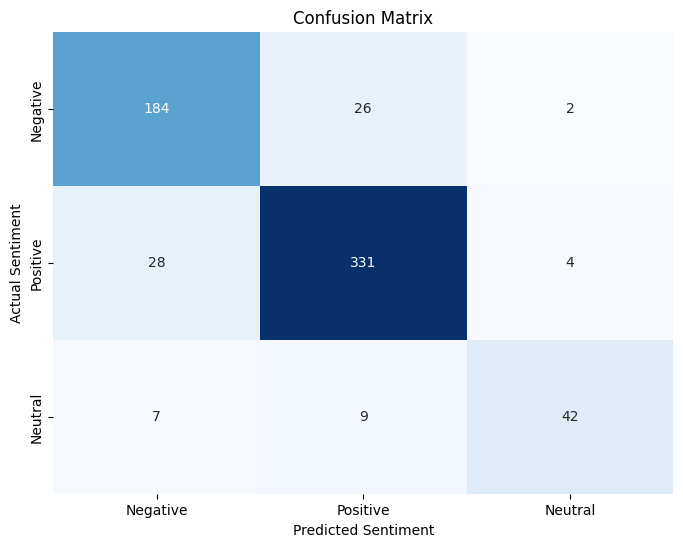

In [ ]:
import json
import pandas as pd
from sklearn.metrics import classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Input and output file paths
input_file = "updated_results_test.json"

# Output files for each condition
error_file = "error.csv"
cant_predict_file = "cant_predict.csv"
mispredict_file = "mispredict.csv"
matched_file = "matched.csv"

# Load data from JSON
with open(input_file, "r") as file:
    data = json.load(file)

# Initialize lists to store entries for each condition
error_data = []
cant_predict_data = []
mispredict_data = []
matched_data = []

# Initialize lists to store sentiments for F1 calculation
true_sentiments = []
predicted_sentiments = []

# Filter entries based on conditions
for entry in data:
    if 'Triplets' not in entry or 'True Triplets' not in entry:
        error_data.append(entry)
        continue  # Skip entries without Triplets or True Triplets

    triplets = entry['Triplets']
    true_triplets = entry['True Triplets']

    if not true_triplets:
        error_data.append(entry)  # Both Triplets and True Triplets are empty
    elif not triplets and true_triplets:
        cant_predict_data.append(entry)  # Triplets are empty but True Triplets are not
    # elif triplets and not true_triplets:
    #     error_data.append(entry)  # True Triplets are empty but Triplets are not
    else:
        # If both Triplets and True Triplets are present
        triplet_set = {(t['Aspect'], t['Opinion'], t['Polarity']) for t in triplets}
        true_triplet_set = {(t['Aspect'], t['Opinion'], t['Polarity']) for t in true_triplets}

        if triplet_set == true_triplet_set:
            matched_data.append(entry)  # Triplets match True Triplets
            # Add to sentiments list for F1 calculation
            for t in true_triplets:
                true_sentiments.append(t['Polarity'])
                predicted_sentiments.append(t['Polarity'])
        else:
            mispredict_data.append(entry)  # Triplets do not match True Triplets
            # Ensure matching lengths
            min_len = min(len(true_triplets), len(triplets))
            for i in range(min_len):
                true_sentiments.append(true_triplets[i]['Polarity'])
                predicted_sentiments.append(triplets[i]['Polarity'])

# Convert lists to DataFrames
error_df = pd.DataFrame(error_data)
cant_predict_df = pd.DataFrame(cant_predict_data)
mispredict_df = pd.DataFrame(mispredict_data)
matched_df = pd.DataFrame(matched_data)

# Save DataFrames to CSV files
error_df.to_csv(error_file, index=False, encoding="utf-8")
cant_predict_df.to_csv(cant_predict_file, index=False, encoding="utf-8")
mispredict_df.to_csv(mispredict_file, index=False, encoding="utf-8")
matched_df.to_csv(matched_file, index=False, encoding="utf-8")

print(f"Filtered data has been saved to {error_file}, {cant_predict_file}, {mispredict_file}, and {matched_file}.")

# Calculate and print F1-score
f1 = f1_score(true_sentiments, predicted_sentiments, average='weighted')
print(f"F1-score: {f1:.2f}")

# Print classification report
report = classification_report(true_sentiments, predicted_sentiments)
print("Classification Report:")
print(report)

# Define labels based on unique sentiment values
labels = list(set(true_sentiments + predicted_sentiments))

# Build confusion matrix
cm = confusion_matrix(true_sentiments, predicted_sentiments, labels=labels)

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.show()